# Packages

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
import torch.nn.functional
import pandas as pd

# Data Preparation

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
combined_dataset = ConcatDataset([train_dataset, test_dataset])
train_size = int(0.7 * len(combined_dataset))
valid_size = int(0.1 * len(combined_dataset))

test_size = len(combined_dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(combined_dataset, [train_size, valid_size, test_size])

len(train_dataset), len(valid_dataset), len(test_dataset)

100%|██████████| 9912422/9912422 [00:00<00:00, 52116607.89it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 81081455.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27547754.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12314498.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(49000, 7000, 14000)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


# Model Building

In [ ]:
#Model 1 with one hidden layer
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x, activation):
        x = x.view(-1, 28*28)
        x = activation(self.fc1(x)) #can change this activation layer
        x = self.fc2(x)
        return x
model_nn1 = Net1()
criterion = nn.CrossEntropyLoss()
optimizer_nn1 = torch.optim.Adam(model_nn1.parameters(), lr=0.001)

In [ ]:
#Model 2 with two hidden layers
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 40)
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x, activation1, activation2):
        x = x.view(-1, 28*28)
        x = activation1(self.fc1(x)) #can change this activation layer
        x = activation2(self.fc2(x)) #can change this activation layer
        x = self.fc3(x)
        return x

model_nn2 = Net2()
criterion = nn.CrossEntropyLoss()
optimizer_nn2 = torch.optim.Adam(model_nn2.parameters(), lr=0.001)

In [ ]:
#Model 3 with three hidden layers
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 80)
        self.fc2 = nn.Linear(80, 40)
        self.fc3 = nn.Linear(40, 20)
        self.fc4 = nn.Linear(20, 10)

    def forward(self, x, activation1, activation2, activation3):
        x = x.view(-1, 28*28)
        x = activation1(self.fc1(x)) #can change this activation layer
        x = activation2(self.fc2(x)) #can change this activation layer
        x = activation3(self.fc3(x)) #can change this activation layer
        x = self.fc4(x)
        return x
model_nn3 = Net3()
criterion = nn.CrossEntropyLoss()
optimizer_nn3 = torch.optim.Adam(model_nn3.parameters(), lr=0.001)

# Training with Validation and Patience

## Train One Hiden Layer NN1 Model

In [ ]:
import torch
torch.manual_seed(42)
# Set seed for GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

import time
results_nn1 = {}
num_epochs = 200
min_validation_loss = float('inf')
patiences = 10
counter = 0
torch.manual_seed(42)
one_layer_comparison =[]
activation_functions = {
    'ReLU': torch.relu,
    'Tanh': torch.tanh,
    'Leaky_relu': torch.nn.functional.leaky_relu,
    'Sigmoid': torch.sigmoid
}

#--------------------for loop with different activation function
for activation_name, activation_function in activation_functions.items():
    start_time = time.time()
    results_nn1[(activation_name)] = {"Epochs": [], "train_accuracy": [], "train_losses": [],
                                    "valid_losses":[], "valid_accuracy":[], "times": []}
    print(f"Activation Function: {activation_name}")
    counter = 0
    min_validation_loss = float('inf')
    optimizer_nn1.zero_grad()
    for epoch in range(num_epochs):
        #-------------Training---------------------------------------------------

        tot_train = 0
        right_train = 0

        for data in train_loader:
            inputs, labels = data
            optimizer_nn1.zero_grad()
            outputs = model_nn1(inputs, activation_function)
            loss = criterion(outputs, labels) # output from model nn1,
            loss.backward() #then .backward() will compute gradients only for nn1's parameters involved in the forward pass
            optimizer_nn1.step() #update weights
            running_loss = loss.item()# just the loss value as a float
            scores, predicted = torch.max(outputs.data, 1) # predicted: predicted classes; outputs.data only gives you score
            tot_train += labels.size(0)
            right_train += (predicted == labels).sum().item()
        train_accuracy = 100 * right_train/tot_train

        #----------------Validation------------------------------------------------
        right_valid = 0
        tot_valid = 0
        with torch.no_grad():# wrap the evaluation codes and do not need to update weights
            for data in valid_loader:
                valid_running_loss = 0
                inputs, labels = data
                outputs = model_nn1(inputs, activation_function)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data,1)# 1: for each row(image)give me the higest score, and tell me which column it's in
                tot_valid += labels.size(0) # first batch size
                right_valid += (predicted == labels).sum().item()
                valid_running_loss += loss.item()
        valid_accuracy = 100 * right_valid / tot_valid
        train_losses = running_loss / len(train_loader)
        valid_loss = valid_running_loss / len(valid_loader)

        # --------------Early Stopping----------------------------------
        if valid_loss < min_validation_loss:
          min_validation_loss = valid_loss  # Update only when there is improvement
          counter = 0
        else:
          counter += 1
          if counter >= patiences:
             torch.save(model_nn1.state_dict(), f"best_model_{activation_name}.pth")
             print("Early stopping triggered.")
             print(f"Activation_function:{activation_name},Validation Loss: {valid_running_loss / len(valid_loader):.3f}" )
             one_layer_comparison.append({
                                      "Epochs": epoch +1,
                                      "Activation Function": activation_name,

                                      "Validation Loss": valid_running_loss / len(valid_loader)
                                  })
             break
        results_nn1[(activation_name)]["train_losses"].append(running_loss/len(train_loader))
        results_nn1[(activation_name)]["train_accuracy"].append(train_accuracy)
        results_nn1[(activation_name)]["valid_accuracy"].append(100 * right_valid / tot_valid)
        results_nn1[(activation_name)]["valid_losses"].append(valid_running_loss / len(valid_loader))
        results_nn1[(activation_name)]["times"].append(time.time() - start_time)
        results_nn1[(activation_name)]["Epochs"].append(epoch+1)
        #-------------------------------------------------------------------
        print(f"[Epoch {epoch+1}] Loss: {running_loss/len(train_loader):.3f},Validation Loss: {valid_running_loss / len(valid_loader):.3f} ,Train Accuracy: {100 * right_train/tot_train:.2f}%", f"Validation Accuracy: {100 * right_valid / tot_valid:.2f}%")

Activation Function: ReLU
[Epoch 1] Loss: 0.016,Validation Loss: 0.118 ,Train Accuracy: 64.26% Validation Accuracy: 82.06%
[Epoch 2] Loss: 0.010,Validation Loss: 0.076 ,Train Accuracy: 84.37% Validation Accuracy: 87.06%
[Epoch 3] Loss: 0.009,Validation Loss: 0.063 ,Train Accuracy: 87.81% Validation Accuracy: 88.87%
[Epoch 4] Loss: 0.007,Validation Loss: 0.058 ,Train Accuracy: 89.26% Validation Accuracy: 89.71%
[Epoch 5] Loss: 0.007,Validation Loss: 0.054 ,Train Accuracy: 90.07% Validation Accuracy: 90.26%
[Epoch 6] Loss: 0.006,Validation Loss: 0.052 ,Train Accuracy: 90.61% Validation Accuracy: 90.74%
[Epoch 7] Loss: 0.007,Validation Loss: 0.051 ,Train Accuracy: 90.87% Validation Accuracy: 90.57%
[Epoch 8] Loss: 0.007,Validation Loss: 0.050 ,Train Accuracy: 91.14% Validation Accuracy: 91.21%
[Epoch 9] Loss: 0.005,Validation Loss: 0.049 ,Train Accuracy: 91.46% Validation Accuracy: 91.13%
[Epoch 10] Loss: 0.006,Validation Loss: 0.048 ,Train Accuracy: 91.58% Validation Accuracy: 91.34%
[Ep

In [ ]:
import pandas as pd
One_layer_comparison = pd.DataFrame(one_layer_comparison)
One_layer_comparison = One_layer_comparison.sort_values(by='Validation Loss')
One_layer_comparison  = One_layer_comparison.reset_index(drop = True)
display(One_layer_comparison)

,Epochs,Activation Function,Validation Loss
0,79,Sigmoid,0.028214
1,71,ReLU,0.030085
2,64,Leaky_relu,0.031970
3,79,Tanh,0.032218


In [ ]:
nn1_activation_function = None
for k,v in activation_functions.items():
	if k == One_layer_comparison['Activation Function'][0]:
		nn1_activation_name = k
		nn1_activation_function = v
model_nn1_saved = f"best_model_{nn1_activation_name}.pth"

In [ ]:
class Net1(nn.Module):
    def __init__(self, activation=nn1_activation_function):  # Set a default activation function
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 20)
        self.fc2 = nn.Linear(20, 10)
        self.activation = activation

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))  # Use the activation function set in __init__
        x = self.fc2(x)
        return x
model_nn1 = Net1()
model_nn1.load_state_dict(torch.load(model_nn1_saved))

<All keys matched successfully>

In [ ]:
model_nn1.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_nn1(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy_nn1 = 100 * correct_test / total_test
test_accuracy_nn1

95.06428571428572

In [ ]:
Result_nn1 = pd.DataFrame(results_nn1[(nn1_activation_name)])
Result_nn1

,Epochs,train_accuracy,train_losses,valid_losses,valid_accuracy,times
0,1,93.046939,0.007247,0.057211,93.657143,2.419956
1,2,95.038776,0.006249,0.049379,93.828571,4.804375
2,3,95.122449,0.005803,0.045398,93.942857,7.204843
3,4,95.134694,0.005458,0.042970,93.914286,9.589229
4,5,95.187755,0.005237,0.041129,93.957143,11.992239
...,...,...,...,...,...,...
73,74,97.334694,0.001577,0.028379,95.300000,180.111344
74,75,97.369388,0.002147,0.028177,95.342857,182.509080
75,76,97.330612,0.002257,0.028026,95.242857,184.909445
76,77,97.391837,0.002263,0.028531,95.357143,187.404528


## Two Hiden Layer NN2

In [ ]:
num_epochs = 200
patiences = 10
torch.manual_seed(42)



activation_functions = {
    'ReLU': torch.relu,
    'Leaky_ReLU': torch.nn.functional.leaky_relu,
    'Tanh': torch.tanh,
    'Sigmoid': torch.sigmoid
}

results_nn2 = {}

two_layers_comparison = []

for activation_name1, activation_function1 in activation_functions.items():
    for activation_name2, activation_function2 in activation_functions.items():
        optimizer_nn2.zero_grad()
        results_nn2[activation_name1, activation_name2] = {"Epochs": [], "train_accuracy": [], "train_losses": [],
                                                            "valid_losses":[], "valid_accuracy":[], "times": []}
        min_validation_loss = float('inf')
        counter = 0
        start_time = time.time()
        print(f"\nRunning Model with... Layer 1 Activation Function: {activation_name1}, Layer 2 Activation Function: {activation_name2}...")
        for epoch in range(num_epochs):
            tot_train = 0
            right_train = 0
            #-------------------------2 hidden layers training---------------------------------
            for data in train_loader:
                inputs, labels = data
                optimizer_nn2.zero_grad()
                outputs = model_nn2(inputs, activation_function1, activation_function2)
                loss = criterion(outputs, labels) # output from model nn1,
                loss.backward() #then .backward() will compute gradients only for model's parameters involved in the forward pass
                optimizer_nn2.step() #update weights
                running_loss = loss.item()# just the loss value as a float
                scores, predicted = torch.max(outputs.data, 1) # predicted: predicted classes; outputs.data only gives you score
                tot_train += labels.size(0)
                right_train += (predicted == labels).sum().item()


            #----------------------2 hidden layers validation------------------------------------
            right_valid = 0
            tot_valid = 0
            with torch.no_grad():# wrap the evaluation codes and do not need to update weights
                for data in valid_loader:
                    valid_running_loss = 0
                    inputs, labels = data
                    outputs = model_nn2(inputs, activation_function1,activation_function2)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data,1)# 1: for each row(image)give me the higest score, and tell me which column it's in
                    tot_valid += labels.size(0) # first batch size
                    right_valid += (predicted == labels).sum().item()
                    valid_running_loss += loss.item()
            valid_loss = valid_running_loss / len(valid_loader)



            #----------------------Early stopping------------------------------------
            if valid_loss < min_validation_loss:
                min_validation_loss = valid_loss  # Fixed to valid_loss
                counter = 0
            elif valid_loss >= min_validation_loss:
                counter += 1
                if counter >= patiences:
                    model_save_name = f"best_model_{activation_name1}_{activation_name2}.pth"
                    torch.save(model_nn2.state_dict(), model_save_name)
                    print("Early stopping triggered.")
                    print(f"1st Activation_function:{activation_name1}, 2nd Activation_function:{activation_name2}, minValidation Loss: {min_validation_loss:.3f}" )
                    two_layers_comparison.append({
                        "Epochs": epoch +1,
                        "1st Activation Function": activation_name1,
                        "2nd Activation Function": activation_name2,
                        "Validation Loss": valid_loss
                    })
                    break  # Break out of the loop if no improvement
            # Record metrics
            results_nn2[(activation_name1, activation_name2)]["train_losses"].append(running_loss/len(train_loader))
            results_nn2[(activation_name1, activation_name2)]["train_accuracy"].append(train_accuracy)
            results_nn2[(activation_name1, activation_name2)]["valid_accuracy"].append(100 * right_valid / tot_valid)
            results_nn2[(activation_name1, activation_name2)]["valid_losses"].append(valid_running_loss / len(valid_loader))
            results_nn2[(activation_name1, activation_name2)]["times"].append(time.time() - start_time)
            results_nn2[(activation_name1, activation_name2)]["Epochs"].append(epoch+1)

            print(f"[Epoch {epoch+1}] Training Loss: {running_loss/len(train_loader):.3f}, Train Accuracy: {100 * right_train/tot_train:.2f}%, Validation Loss: {valid_running_loss / len(valid_loader):.3f}, Validation Accuracy: {100 * right_valid / tot_valid:.2f}%")



Running Model with... Layer 1 Activation Function: ReLU, Layer 2 Activation Function: ReLU...
[Epoch 1] Training Loss: 0.023, Train Accuracy: 45.90%, Validation Loss: 0.157, Validation Accuracy: 71.01%
[Epoch 2] Training Loss: 0.012, Train Accuracy: 78.56%, Validation Loss: 0.090, Validation Accuracy: 83.70%
[Epoch 3] Training Loss: 0.009, Train Accuracy: 85.80%, Validation Loss: 0.069, Validation Accuracy: 87.91%
[Epoch 4] Training Loss: 0.007, Train Accuracy: 88.49%, Validation Loss: 0.060, Validation Accuracy: 89.44%
[Epoch 5] Training Loss: 0.007, Train Accuracy: 89.64%, Validation Loss: 0.056, Validation Accuracy: 90.14%
[Epoch 6] Training Loss: 0.006, Train Accuracy: 90.30%, Validation Loss: 0.053, Validation Accuracy: 90.66%
[Epoch 7] Training Loss: 0.007, Train Accuracy: 90.95%, Validation Loss: 0.051, Validation Accuracy: 90.87%
[Epoch 8] Training Loss: 0.007, Train Accuracy: 91.36%, Validation Loss: 0.049, Validation Accuracy: 91.33%
[Epoch 9] Training Loss: 0.005, Train Acc

In [ ]:
Two_layer_comparison = pd.DataFrame(two_layers_comparison)
Two_layer_comparison = Two_layer_comparison.sort_values(by='Validation Loss')
Two_layer_comparison  = Two_layer_comparison.reset_index(drop = True)
display(Two_layer_comparison)

,Epochs,1st Activation Function,2nd Activation Function,Validation Loss
0,36,Leaky_ReLU,Sigmoid,0.021828
1,59,ReLU,Sigmoid,0.023249
2,13,ReLU,Leaky_ReLU,0.023920
3,92,ReLU,ReLU,0.024094
4,39,Sigmoid,Sigmoid,0.024864
5,24,Tanh,Sigmoid,0.026598
6,44,ReLU,Tanh,0.026930
7,13,Leaky_ReLU,Tanh,0.030974
8,16,Sigmoid,Tanh,0.031916
9,23,Tanh,Tanh,0.032463


In [ ]:
activation_functions = {
    'ReLU': torch.relu,
    'Leaky_ReLU': torch.nn.functional.leaky_relu,
    'Tanh': torch.tanh,
    'Sigmoid': torch.sigmoid
}

In [ ]:
nn2_activation_function1 = None
for k,v in activation_functions.items():
	if k == Two_layer_comparison['1st Activation Function'][0]:
		nn2_activation_name1 = k
		nn2_activation_function1 = v
nn2_activation_function2 = None
for k,v in activation_functions.items():
	if k == Two_layer_comparison['2nd Activation Function'][0]:
		nn2_activation_name2 = k
		nn2_activation_function2 = v
model_nn2_saved = f"best_model_{activation_name1}_{activation_name2}.pth"

In [ ]:
#Model 2 with two hidden layers
class Net2(nn.Module):
    def __init__(self, activation1 = nn2_activation_function1, activation2 = nn2_activation_function2):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 40)
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 10)
        self.activation1 = activation1
        self.activation2 = activation2


    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation1(self.fc1(x)) #can change this activation layer
        x = self.activation2(self.fc2(x)) #can change this activation layer
        x = self.fc3(x)
        return x
model_nn2 = Net2()
model_nn2.load_state_dict(torch.load(model_nn2_saved))

<All keys matched successfully>

In [ ]:
model_nn2.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_nn2(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy_nn2 = 100 * correct_test / total_test
test_accuracy_nn2

96.25

In [ ]:
Result_nn2 = pd.DataFrame(results_nn2[(nn2_activation_name1, nn2_activation_name2)])
Result_nn2

,Epochs,train_accuracy,train_losses,valid_losses,valid_accuracy,times
0,1,97.026531,0.001668,0.025153,95.842857,2.439044
1,2,97.026531,0.001371,0.024179,95.928571,5.037007
2,3,97.026531,0.001728,0.023593,96.028571,7.638301
3,4,97.026531,0.001708,0.023415,96.157143,10.220863
4,5,97.026531,0.001419,0.022819,96.228571,12.722513
5,6,97.026531,0.001129,0.022772,96.142857,15.182847
6,7,97.026531,0.001394,0.023049,96.200000,17.643029
7,8,97.026531,0.001248,0.023085,96.171429,20.352879
8,9,97.026531,0.001065,0.023254,96.157143,22.943306
9,10,97.026531,0.001222,0.022558,96.300000,25.514140


## Three Hidden Layers NN3

In [ ]:
#Model 3 with three hidden layers
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 80)
        self.fc2 = nn.Linear(80, 40)
        self.fc3 = nn.Linear(40, 20)
        self.fc4 = nn.Linear(20, 10)

    def forward(self, x, activation1, activation2, activation3):
        x = x.view(-1, 28*28)
        x = activation1(self.fc1(x)) #can change this activation layer
        x = activation2(self.fc2(x)) #can change this activation layer
        x = activation3(self.fc3(x)) #can change this activation layer
        x = self.fc4(x)
        return x
model_nn3 = Net3()
optimizer_nn3 = torch.optim.Adam(model_nn3.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
num_epochs = 150
patiences = 10
three_layers_comparison = []
activation_functions = {
    'ReLU': torch.relu,
    'Leaky_relu': torch.nn.functional.leaky_relu,
    'Tanh': torch.tanh,
    'Sigmoid': torch.sigmoid
}
results_nn3 = {}
for activation_name1, activation_function1 in activation_functions.items():
    for activation_name2, activation_function2 in activation_functions.items():
      for activation_name3, activation_function3 in activation_functions.items():
        start_time = time.time()
        results_nn3[activation_name1, activation_name2, activation_name3] = {"Epochs": [], "train_accuracy": [], "train_losses": [],
                                                                             "valid_losses":[], "valid_accuracy":[], "times": []}
        min_validation_loss = float('inf')
        counter = 0
        optimizer_nn3.zero_grad()
        print(f"Layer 1 Activation Function: {activation_name1}, Layer 2 Activation Function: {activation_name2},  Layer 3 Activation Function: {activation_name3}")
        for epoch in range(num_epochs):
            tot_train = 0
            right_train = 0
            #-------------------------3 hiden layers training---------------------------------
            for data in train_loader:
                inputs, labels = data
                optimizer_nn3.zero_grad()
                outputs = model_nn3(inputs, activation_function1, activation_function2, activation_function3)
                loss = criterion(outputs, labels) # output from model nn1,
                loss.backward() #then .backward() will compute gradients only for model's parameters involved in the forward pass
                optimizer_nn3.step() #update weights
                running_loss = loss.item()# just the loss value as a float
                scores, predicted = torch.max(outputs.data, 1) # predicted: predicted classes; outputs.data only gives you score
                tot_train += labels.size(0)
                right_train += (predicted == labels).sum().item()
            train_accuracy = 100 * right_train/tot_train
            train_losses = running_loss / len(train_loader)


            #----------------------3 hiden layers validation------------------------------------
            right_valid = 0
            tot_valid = 0
            with torch.no_grad():# wrap the evaluation codes and do not need to update weights
                for data in valid_loader:
                    valid_running_loss = 0
                    inputs, labels = data
                    outputs = model_nn3(inputs, activation_function1,activation_function2, activation_function3)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data,1)# 1: for each row(image)give me the higest score, and tell me which column it's in
                    tot_valid += labels.size(0) # first batch size
                    right_valid += (predicted == labels).sum().item()
                    valid_running_loss += loss.item()
            valid_accuracy = 100 * right_valid / tot_valid
            valid_loss = valid_running_loss / len(valid_loader)

            #----------------------Early stopping------------------------------------
            if valid_loss < min_validation_loss:
                min_validation_loss = valid_loss  # Fixed to valid_loss
                counter = 0
            elif valid_loss >= min_validation_loss:
                counter += 1
                if counter >= patiences:
                    model_save_name = f"best_model_{activation_name1}_{activation_name2}_{activation_name3}.pth"
                    torch.save(model_nn3.state_dict(), model_save_name)
                    print("Early stopping triggered.")
                    print(f"1st Activation_function:{activation_name1}, 2nd Activation_function:{activation_name2}, 3rd Activation_function:{activation_name3},minValidation Loss: {min_validation_loss:.3f}" )
                    three_layers_comparison.append({
                                      "Epochs": epoch +1,
                                      "1st Activation Function": activation_name1,
                                      "2nd Activation Function": activation_name2,
                                      "3rd Activation Function": activation_name3,
                                      "Validation Loss": valid_running_loss / len(valid_loader)
                                  })
                    break  # Break out of the loop if no improvement """
            results_nn3[(activation_name1, activation_name2, activation_name3)]["train_losses"].append(running_loss/len(train_loader))
            results_nn3[(activation_name1, activation_name2, activation_name3)]["train_accuracy"].append(train_accuracy)
            results_nn3[(activation_name1, activation_name2, activation_name3)]["valid_accuracy"].append(100 * right_valid / tot_valid)
            results_nn3[(activation_name1, activation_name2, activation_name3)]["valid_losses"].append(valid_running_loss / len(valid_loader))
            results_nn3[(activation_name1, activation_name2, activation_name3)]["times"].append(time.time() - start_time)
            results_nn3[(activation_name1, activation_name2, activation_name3)]["Epochs"].append(epoch+1)
            print(f"[Epoch {epoch+1}] Loss: {running_loss/len(train_loader):.3f},Validation Loss: {valid_running_loss / len(valid_loader):.3f} ,Train Accuracy: {100 * right_train/tot_train:.2f}%", f"Validation Accuracy: {100 * right_valid / tot_valid:.2f}%")

Layer 1 Activation Function: ReLU, Layer 2 Activation Function: ReLU,  Layer 3 Activation Function: ReLU
[Epoch 1] Loss: 0.019,Validation Loss: 0.126 ,Train Accuracy: 50.81% Validation Accuracy: 74.33%
[Epoch 2] Loss: 0.010,Validation Loss: 0.076 ,Train Accuracy: 81.08% Validation Accuracy: 85.74%
[Epoch 3] Loss: 0.008,Validation Loss: 0.060 ,Train Accuracy: 87.18% Validation Accuracy: 89.01%
[Epoch 4] Loss: 0.006,Validation Loss: 0.053 ,Train Accuracy: 89.49% Validation Accuracy: 90.01%
[Epoch 5] Loss: 0.007,Validation Loss: 0.048 ,Train Accuracy: 90.55% Validation Accuracy: 90.84%
[Epoch 6] Loss: 0.005,Validation Loss: 0.045 ,Train Accuracy: 91.43% Validation Accuracy: 91.34%
[Epoch 7] Loss: 0.006,Validation Loss: 0.044 ,Train Accuracy: 92.07% Validation Accuracy: 91.73%
[Epoch 8] Loss: 0.006,Validation Loss: 0.041 ,Train Accuracy: 92.63% Validation Accuracy: 92.20%
[Epoch 9] Loss: 0.004,Validation Loss: 0.038 ,Train Accuracy: 93.01% Validation Accuracy: 92.73%
[Epoch 10] Loss: 0.004

In [ ]:
Three_layers_comparison = pd.DataFrame(three_layers_comparison)
Three_layers_comparison = Three_layers_comparison.sort_values(by='Validation Loss')
Three_layers_comparison  = Three_layers_comparison.reset_index(drop = True)
display(Three_layers_comparison)

,Epochs,1st Activation Function,2nd Activation Function,3rd Activation Function,Validation Loss
0,40,ReLU,ReLU,Sigmoid,0.017200
1,12,ReLU,Sigmoid,Sigmoid,0.018191
2,12,Leaky_relu,Sigmoid,Sigmoid,0.018531
3,13,ReLU,Leaky_relu,Sigmoid,0.018718
4,27,ReLU,ReLU,Tanh,0.018925
...,...,...,...,...,...
59,15,Tanh,Tanh,Leaky_relu,0.067834
60,12,Leaky_relu,Leaky_relu,ReLU,0.089845
61,12,Leaky_relu,ReLU,ReLU,0.093106
62,11,Leaky_relu,Leaky_relu,Leaky_relu,0.102575


In [ ]:
activation_functions = {
    'ReLU': torch.relu,
    'Leaky_ReLU': torch.nn.functional.leaky_relu,
    'Tanh': torch.tanh,
    'Sigmoid': torch.sigmoid
}
nn3_activation_function1 = None
for k,v in activation_functions.items():
	if k == Three_layers_comparison['1st Activation Function'][0]:
		nn3_activation_name1 = k
		nn3_activation_function1 = v
nn3_activation_function2 = None
for k,v in activation_functions.items():
	if k == Three_layers_comparison['2nd Activation Function'][0]:
		nn3_activation_name2 = k
		nn3_activation_function2 = v
nn3_activation_function3 = None
for k,v in activation_functions.items():
	if k == Three_layers_comparison['3rd Activation Function'][0]:
		nn3_activation_name3 = k
		nn3_activation_function3 = v
model_nn3_saved = f"best_model_{activation_name1}_{activation_name2}_{activation_name3}.pth"

In [ ]:
#Model 3 with three hidden layers
class Net3(nn.Module):
    def __init__(self, activation1 = nn3_activation_function1, activation2 = nn3_activation_function2, activation3 = nn3_activation_function3):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 80)
        self.fc2 = nn.Linear(80, 40)
        self.fc3 = nn.Linear(40, 20)
        self.fc4 = nn.Linear(20, 10)
        self.activation1 = activation1
        self.activation2 = activation2
        self.activation3 = activation3

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation1(self.fc1(x))
        x = self.activation2(self.fc2(x))
        x = self.activation3(self.fc3(x))
        x = self.fc4(x)
        return x

model_nn3 = Net3()
model_nn3.load_state_dict(torch.load(model_nn3_saved))

<All keys matched successfully>

In [ ]:
model_nn3.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_nn3(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy_nn3 = 100 * correct_test / total_test
test_accuracy_nn3

96.98571428571428

In [ ]:
Result_nn3 = pd.DataFrame(results_nn3[(activation_name1,activation_name2, activation_name3)])
Result_nn3

,Epochs,train_accuracy,train_losses,valid_losses,valid_accuracy,times
0,1,98.642857,0.003460,0.032379,96.814286,2.444430
1,2,98.673469,0.002858,0.027981,96.842857,4.895528
2,3,98.693878,0.002305,0.025687,96.828571,7.330381
3,4,98.793878,0.002070,0.023584,96.857143,9.768616
4,5,98.879592,0.002044,0.022510,97.000000,12.206867
5,6,98.806122,0.001469,0.020832,97.000000,14.784952
6,7,98.914286,0.001726,0.021069,96.971429,17.224448
7,8,98.924490,0.001509,0.019615,97.028571,19.664622
8,9,98.991837,0.001615,0.019946,96.942857,22.101744
9,10,98.981633,0.001523,0.019168,97.114286,24.539327


In [ ]:
models = {
    "Model 1: NN1": {"train accuracy": results_nn1[nn1_activation_name]["train_accuracy"][-1], "test accuracy": test_accuracy_nn1, "time": results_nn1[nn1_activation_function]["times"][-1]},
    "Model 2: NN2": {"train accuracy": results_nn2[(nn2_activation_name1, nn2_activation_name2)]["train_accuracy"][-1], "test accuracy": test_accuracy_nn2, "time": results_nn2[(nn2_activation_function1, nn2_activation_function2)]["times"][-1]},
    "Model 3: NN3": {"train accuracy": results_nn3[(nn3_activation_name1, nn3_activation_name2, nn3_activation_name3)]['train_accuracy'][-1], "test accuracy": test_accuracy_nn3, "time": results_nn3[(nn3_activation_function1,nn3_activation_function2, nn3_activation_function3)]['times'][-1]}
}
df = pd.DataFrame(models)
df

In [ ]:
models = {
    "Model 1: NN1": {"train accuracy": results_nn1[nn1_activation_name]["train_accuracy"][-1], "test accuracy": test_accuracy_nn1, "time": results_nn1[nn1_activation_name]["times"][-1]},
    "Model 2: NN2": {"train accuracy": results_nn2[(nn2_activation_name1, nn2_activation_name2)]["train_accuracy"][-1], "test accuracy": test_accuracy_nn2, "time": results_nn2[(nn2_activation_name1, nn2_activation_name2)]["times"][-1]},
    "Model 3: NN3": {"train accuracy": results_nn3[(nn3_activation_name1, nn3_activation_name2, nn3_activation_name3)]['train_accuracy'][-1], "test accuracy": test_accuracy_nn3, "time": results_nn3[(nn3_activation_name1,nn3_activation_name2, nn3_activation_name3)]['times'][-1]}
}
df = pd.DataFrame(models)
df

,Model 1: NN1,Model 2: NN2,Model 3: NN3
train accuracy,97.422449,97.026531,99.583673
test accuracy,95.064286,96.250000,96.985714
time,189.783379,87.710653,99.783425


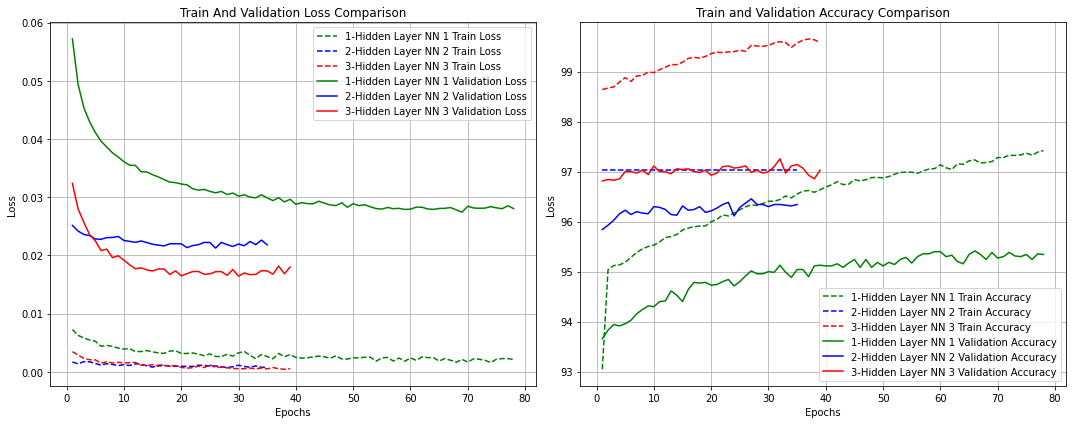

In [ ]:
import matplotlib.pyplot as plt

epochs_nn1_train = range(1, len(Result_nn1['Epochs']) + 1)
epochs_nn1_valid = range(1, len(Result_nn1['Epochs']) + 1)
epochs_nn2_train = range(1, len(Result_nn2['Epochs']) + 1)
epochs_nn2_valid = range(1, len(Result_nn2['Epochs']) + 1)
epochs_nn3_train = range(1, len(Result_nn3['Epochs']) + 1)
epochs_nn3_valid = range(1, len(Result_nn3['Epochs']) + 1)
train_accuracy_nn1 = Result_nn1['train_accuracy']
valid_accuracy_nn1 = Result_nn1['valid_accuracy']
train_accuracy_nn2 = Result_nn2['train_accuracy']
valid_accuracy_nn2 = Result_nn2['valid_accuracy']
train_accuracy_nn3 = Result_nn3['train_accuracy']
valid_accuracy_nn3 = Result_nn3['valid_accuracy']
train_losses_nn1 = Result_nn1['train_losses']
valid_losses_nn1 = Result_nn1['valid_losses']
train_losses_nn2 = Result_nn2['train_losses']
valid_losses_nn2 = Result_nn2['valid_losses']
train_losses_nn3 = Result_nn3['train_losses']
valid_losses_nn3 = Result_nn3['valid_losses']

# Plotting
plt.figure(figsize=(15, 6))

# Train Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_nn1_train, train_losses_nn1, label='1-Hidden Layer NN 1 Train Loss', linestyle='--', color='green')
plt.plot(epochs_nn2_train, train_losses_nn2, label='2-Hidden Layer NN 2 Train Loss', linestyle='--', color='blue')
plt.plot(epochs_nn3_train, train_losses_nn3, label='3-Hidden Layer NN 3 Train Loss', linestyle='--', color='red')
plt.plot(epochs_nn1_valid, valid_losses_nn1, label='1-Hidden Layer NN 1 Validation Loss', color='green')
plt.plot(epochs_nn2_valid, valid_losses_nn2, label='2-Hidden Layer NN 2 Validation Loss', color='blue')
plt.plot(epochs_nn3_valid, valid_losses_nn3, label='3-Hidden Layer NN 3 Validation Loss', color='red')
plt.title('Train And Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Test Loss
plt.subplot(1, 2, 2)

plt.title('Train and Validation Accuracy Comparison')
plt.plot(epochs_nn1_train, train_accuracy_nn1, label='1-Hidden Layer NN 1 Train Accuracy', linestyle='--', color='green')
plt.plot(epochs_nn2_train, train_accuracy_nn2, label='2-Hidden Layer NN 2 Train Accuracy', linestyle='--', color='blue')
plt.plot(epochs_nn3_train, train_accuracy_nn3, label='3-Hidden Layer NN 3 Train Accuracy', linestyle='--', color='red')
plt.plot(epochs_nn1_valid, valid_accuracy_nn1, label='1-Hidden Layer NN 1 Validation Accuracy', color='green')
plt.plot(epochs_nn2_valid, valid_accuracy_nn2, label='2-Hidden Layer NN 2 Validation Accuracy', color='blue')
plt.plot(epochs_nn3_valid, valid_accuracy_nn3, label='3-Hidden Layer NN 3 Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Discussion
In this project, we designed multiple neural network architectures and experimented with different neurons, layers, and activation functions. We designed three models -- the first with one hidden layer, the second with two hidden layers, and the third with three hidden layers. We experimented with a combination of different activation functions for each model, including ReLU, Leaky_ReLU, Tanh, and Sigmoid for each layer, using our training and validation datasets. We used early stopping with patience equal to 10 on our validation set to prevent overfitting. We then used the test dataset to evaluate how well our trained model adapts to the data it has never seen before.  
  
We created three result tables for the different model performances with different activation function(s) combinations. In that table, you will see which activation function(s) were used to train the models. The 'One_layer_comparison,' 'Two_layers_comparison', and 'Third_layers_comparison' tables reflect the models' minimum validation loss when using different activation functions. The activation functions that gave the lowest validation loss for the one, two, and three hidden layers are Sigmoid, Leaky-ReLU/Sigmoid, and ReLU/ReLU/Sigmoid, respectively.   
  
The table and graphs above allow each best model (NN1, NN2, and NN3) to record and show the model's training time, accuracies, and losses.  

In the evaluation of our three neural network models,  NN3 showcased a training accuracy at 99.58%, outperforming NN1 (97.42%) and NN2 (97.03%). Similarly, NN3 had the greatest test accuracy of  96.99%, followed by NN2 at 96.25%, and NN1 at 95.06%. Interestingly, NN2 proved to be the most time-efficient during training, completing in 87.71 seconds, while NN1 and NN3 required 189.78 and 99.78 seconds, respectively.

As we added more hidden layers to our neural network models, it introduced more complexity, increasing the training and validation accuracy and consequently decreasing the training and validation loss. Adding more hidden layers also comes with the risk of overfitting. However, the early stopping condition cuts the number of epochs used to train the models as the number of layers increases.
  
 We saw that it took fewer epochs to fit the data, producing better accuracy without capturing overfitting the data as early stopping kicking in earlier. With one hidden layer, the model captures more noise of the data, as it iterates over many more epochs, with less accurate results as compared to the three hidden layers. The neural network with three hidden layers produces the lowest validation loss and, therefore, the highest validation accuracy and test accuracy.